In [2]:
!cabocha -f1 data/ai/ai.ja.txt > work/ai.ja.txt.parsed

In [3]:
!head -9 work/ai.ja.txt.parsed

* 0 -1D 1/1 0.000000
人工	名詞,一般,*,*,*,*,人工,ジンコウ,ジンコー
知能	名詞,一般,*,*,*,*,知能,チノウ,チノー
EOS
EOS
* 0 17D 1/1 0.388993
人工	名詞,一般,*,*,*,*,人工,ジンコウ,ジンコー
知能	名詞,一般,*,*,*,*,知能,チノウ,チノー
* 1 17D 2/3 0.613549


## 40. 係り受け解析結果の読み込み（形態素）

形態素を表すクラスMorphを実装せよ．このクラスは表層形（surface），基本形（base），品詞（pos），品詞細分類1（pos1）をメンバ変数に持つこととする．さらに，係り受け解析の結果（ai.ja.txt.parsed）を読み込み，各文をMorphオブジェクトのリストとして表現し，冒頭の説明文の形態素列を表示せよ．

In [63]:
import os
from itertools import groupby
from string import printable

class Morph:
    def __init__(self,line):
        self.surface, temp = line.rstrip().split('\t')
        inf = temp.split(',')
        self.pos = inf[0]
        self.pos1 = inf[1]
        self.base = inf[6]
        
    #クラスメソッドはクラスでインスタンスにしなくても使える 第1引数はselfではなくclsになる
    @classmethod 
    def load_cabocha(cls, fi):
        for is_eos, sentence in groupby(fi, key=lambda x: x == 'EOS\n'):
            #EOS\nで区切ってくれる
            if not is_eos:
                #かかり受けの情報とかを除去
                yield [cls(line) for line in sentence if not line.startswith('* ')]
    
        
    def __repr__(self):
        return '({})'.format(', '.join((self.surface, self.pos, self.pos1,self.base)))
                

data_path = os.path.join("work","ai.ja.txt.parsed")

with open(data_path) as f:
    for i, sent in enumerate(Morph.load_cabocha(f)):
        if i==1:
            print(repr(sent))


[(人工, 名詞, 一般, 人工), (知能, 名詞, 一般, 知能), (（, 記号, 括弧開, （), (じん, 名詞, 一般, じん), (こうち, 名詞, 一般, こうち), (のう, 助詞, 終助詞, のう), (、, 記号, 読点, 、), (、, 記号, 読点, 、), (AI, 名詞, 一般, *), (〈, 記号, 括弧開, 〈), (エーアイ, 名詞, 固有名詞, *), (〉, 記号, 括弧閉, 〉), (）, 記号, 括弧閉, ）), (と, 助詞, 格助詞, と), (は, 助詞, 係助詞, は), (、, 記号, 読点, 、), (「, 記号, 括弧開, 「), (『, 記号, 括弧開, 『), (計算, 名詞, サ変接続, 計算), (（, 記号, 括弧開, （), (）, 記号, 括弧閉, ）), (』, 記号, 括弧閉, 』), (という, 助詞, 格助詞, という), (概念, 名詞, 一般, 概念), (と, 助詞, 並立助詞, と), (『, 記号, 括弧開, 『), (コンピュータ, 名詞, 一般, コンピュータ), (（, 記号, 括弧開, （), (）, 記号, 括弧閉, ）), (』, 記号, 括弧閉, 』), (という, 助詞, 格助詞, という), (道具, 名詞, 一般, 道具), (を, 助詞, 格助詞, を), (用い, 動詞, 自立, 用いる), (て, 助詞, 接続助詞, て), (『, 記号, 括弧開, 『), (知能, 名詞, 一般, 知能), (』, 記号, 括弧閉, 』), (を, 助詞, 格助詞, を), (研究, 名詞, サ変接続, 研究), (する, 動詞, 自立, する), (計算, 名詞, サ変接続, 計算), (機, 名詞, 接尾, 機), (科学, 名詞, 一般, 科学), (（, 記号, 括弧開, （), (）, 記号, 括弧閉, ）), (の, 助詞, 連体化, の), (一, 名詞, 数, 一), (分野, 名詞, 一般, 分野), (」, 記号, 括弧閉, 」), (を, 助詞, 格助詞, を), (指す, 動詞, 自立, 指す), (語, 名詞, 一般, 語), (。, 記号, 句点, 。), (「, 記号, 括弧開, 「), (言語, 名詞, 一般, 言語), (の, 助

## 41. 係り受け解析結果の読み込み（文節・係り受け）

40に加えて，文節を表すクラスChunkを実装せよ．このクラスは形態素（Morphオブジェクト）のリスト（morphs），係り先文節インデックス番号（dst），係り元文節インデックス番号のリスト（srcs）をメンバ変数に持つこととする．さらに，入力テキストの係り受け解析結果を読み込み，１文をChunkオブジェクトのリストとして表現し，冒頭の説明文の文節の文字列と係り先を表示せよ．本章の残りの問題では，ここで作ったプログラムを活用せよ．

In [147]:
#表示の際に表層形を出すように上書き
class Morph(Morph):
    def __repr__(self):
        return (self.surface)

class Chunk:
    def __init__(self, line):
        info = line.rstrip().split()
        self.idx = int(info[1])#文内の文節番号
        self.dst = int(info[2].rstrip("D")) ##かかり先
        self.morphs = []
        self.srcs = []
        
    def srcs_append(self, src_idx):
        """係り元文節インデックスを追加"""
        self.srcs.append(src_idx)
        
    def morphs_append(self, line):
        """形態素を追加"""
        self.morphs.append(Morph(line))
    
    def __str__(self):
        return ''.join([morph.surface for morph in self.morphs])
        
    def __repr__(self):
        return '({}, dst:{})'.format(self.morphs, self.dst)
#         

class Sentence:
    def __init__(self, sent_lines):
        self.chunks = []
        
        ##ここでとりあえず全ての文節を取り込む
        for line in sent_lines:  
            if line.startswith('* '):
                self.chunks.append(Chunk(line))
            else:
                #作成済みのchunkクラスに文節を入れる
                self.chunks[-1].morphs_append(line)
 
        #かかりもとのidを結ぶ
        for chunk in self.chunks:
            if chunk.dst != -1:
                self.chunks[chunk.dst].srcs_append(chunk.idx)
    

    @classmethod
    def load_cabocha(cls, fi):
        """cabocha lattice formatファイルからSentenceインスタンスを生成"""
        for is_eos, sentence in groupby(fi, key=lambda x: x == 'EOS\n'):
            if not is_eos:
                yield cls(sentence)
                
    def print_dep_idx(self):
        """係り元文節インデックスと係り先文節インデックスを表示"""
        for chunk in self.chunks:
            print('{}:{} => {}'.format(chunk.idx, chunk, chunk.dst))
                
                
data_path = os.path.join("work","ai.ja.txt.parsed")

with open(data_path) as f:
    for i, sent in enumerate(Sentence.load_cabocha(f)):
        if i==2:
            sent.print_dep_idx()
            break

0:『日本大百科全書(ニッポニカ)』の => 1
1:解説で、 => 5
2:情報工学者・通信工学者の => 3
3:佐藤理史は => 5
4:次のように => 5
5:述べている。 => -1


## 42. 係り元と係り先の文節の表示


係り元の文節と係り先の文節のテキストをタブ区切り形式ですべて抽出せよ．ただし，句読点などの記号は出力しないようにせよ．

In [148]:
#クラスとチャンクに以下の２つの機能を追加
class Chunk(Chunk):
    def chunk2str(self):
        """記号を取り除いた文節の表層形を返す"""
        return ''.join([morph.surface for morph in self.morphs if morph.pos != '記号'])
    

class Sentence(Sentence):
    def print_dep(self):
        """係り元文節と係り先文節の表層をタブ区切りで表示"""
        for chunk in self.chunks:
            if chunk.dst != -1:
                print('{}\t{}'.format(chunk.chunk2str(), self.chunks[chunk.dst].chunk2str()))
    

data_path = os.path.join("work","ai.ja.txt.parsed")
with open(data_path) as f:
    for i, sent in enumerate(Sentence.load_cabocha(f)):
        if i==2:
            print(sent.print_dep())
            break

日本大百科全書(ニッポニカ)』の	解説で
解説で	述べている
情報工学者通信工学者の	佐藤理史は
佐藤理史は	述べている
次のように	述べている
None


## 43. 名詞を含む文節が動詞を含む文節に係るものを抽出

名詞を含む文節が，動詞を含む文節に係るとき，これらをタブ区切り形式で抽出せよ．ただし，句読点などの記号は出力しないようにせよ．

In [149]:
#クラスとチャンクに以下の２つの機能を追加
class Chunk(Chunk):
    def contain_pos(self, pos):
        """文節中にある品詞が存在するかどうかを返す"""
        return pos in (morph.pos for morph in self.morphs)
    

class Sentence(Sentence):
    def print_noun_verb_dep(self):
        """名詞を含む文節が動詞を含む文節に係るものを抽出"""
        for chunk in self.chunks:
            if chunk.contain_pos('名詞') and self.chunks[chunk.dst].contain_pos('動詞'):
                print('{}\t{}'.format(chunk.chunk2str(), self.chunks[chunk.dst].chunk2str()))

with open(data_path) as f:
    for i, sent in enumerate(Sentence.load_cabocha(f)):
        if i==2:
            print(sent.print_noun_verb_dep())
            break
            

解説で	述べている
佐藤理史は	述べている
次のように	述べている
None


## 44. 係り受け木の可視化

与えられた文の係り受け木を有向グラフとして可視化せよ．可視化には，Graphviz等を用いるとよい．

In [150]:
import pydot

class Sentence(Sentence):
    def dep_edge(self):
        """pydotで係り受けを出力する用"""
        return [(chunk.chunk2str(), self.chunks[chunk.dst].chunk2str())
                    for chunk in self.chunks if chunk.dst != -1]
    
with open(data_path) as f:
    for i, sent in enumerate(Sentence.load_cabocha(f)):
        if i==2:
            edges = sent.dep_edge()
            n = pydot.Node('node')
            graph = pydot.graph_from_edges(edges, directed=True)
            graph.add_node(n)
            graph.write_jpeg("dep_tree_AI{}.jpg".format(i))
            break    


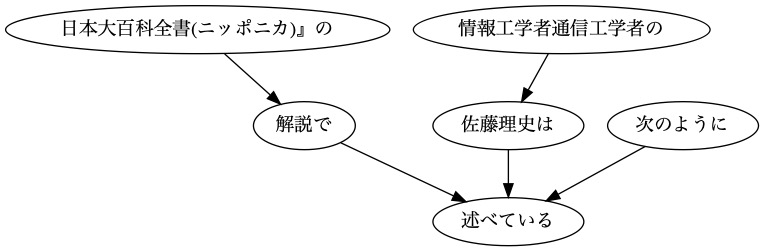

In [151]:
from IPython.display import Image
Image("dep_tree_AI2.jpg")

## 45. 動詞の格パターンの抽出

今回用いている文章をコーパスと見なし，日本語の述語が取りうる格を調査したい． 動詞を述語，動詞に係っている文節の助詞を格と考え，述語と格をタブ区切り形式で出力せよ． ただし，出力は以下の仕様を満たすようにせよ．

動詞を含む文節において，最左の動詞の基本形を述語とする
述語に係る助詞を格とする
述語に係る助詞（文節）が複数あるときは，すべての助詞をスペース区切りで辞書順に並べる
「ジョン・マッカーシーはAIに関する最初の会議で人工知能という用語を作り出した。」という例文を考える． この文は「作り出す」という１つの動詞を含み，「作り出す」に係る文節は「ジョン・マッカーシーは」，「会議で」，「用語を」であると解析された場合は，次のような出力になるはずである．

In [152]:
path_write = os.path.join("work","kakuframe_ai.txt")
with open(data_path) as f,open(path_write,"w") as g: 
    for i, sent in enumerate(Sentence.load_cabocha(f)):
            for chunk in sent.chunks:
                for morph in chunk.morphs:
                    if morph.pos == '動詞':
                        verb = morph.base
                        particles = [] # 助詞のリスト
                        for src in chunk.srcs:
                        # 分節内で一番右の助詞を追加していく
                            particles.extend([word.base for word in sent.chunks[src].morphs 
                                                 if word.pos == '助詞'][-1:])
                        particles.sort()
                        if i==13:
                            print('{}\t{}'.format(verb, ' '.join(particles)))
                        g.write('{}\t{}\n'.format(verb, ' '.join(particles)))
                        break

なる	に
出る	が と に関して
作り出す	で は を
する	は を
ふるまう	
する	を
する	として は を
する	を
行う	を


In [153]:
!head -10  work/kakuframe_ai.txt

用いる	を
する	て を
指す	を
代わる	に を
行う	て に
する	も
述べる	で に は
する	で を
する	を
する	を


In [154]:
! grep -E "^(する|なる|与える)\t" work/kakuframe_ai.txt| sort | uniq -c | sort -nr | head -10

  51 する	を
  18 する	と
  18 する	が
  16 する	に
  13 する	は を
  10 する	に を
   9 する	で を
   8 する	
   7 する	と は
   7 する	が に


## 46. 動詞の格フレーム情報の抽出

45のプログラムを改変し，述語と格パターンに続けて項（述語に係っている文節そのもの）をタブ区切り形式で出力せよ．45の仕様に加えて，以下の仕様を満たすようにせよ．

項は述語に係っている文節の単語列とする（末尾の助詞を取り除く必要はない）
述語に係る文節が複数あるときは，助詞と同一の基準・順序でスペース区切りで並べる
「ジョン・マッカーシーはAIに関する最初の会議で人工知能という用語を作り出した。」という例文を考える． この文は「作り出す」という１つの動詞を含み，「作り出す」に係る文節は「ジョン・マッカーシーは」，「会議で」，「用語を」であると解析された場合は，次のような出力になるはずである

In [155]:
with open(data_path) as f,open(path_write,"w") as g: 
    for i, sent in enumerate(Sentence.load_cabocha(f)):
        if i==13:
            for chunk in sent.chunks:
                for morph in chunk.morphs:
                    if morph.pos == '動詞':
                        verb = morph.base
                        particle_chunks = []
                        for src in chunk.srcs:
                            # (助詞, 係り元の分節の表層)
                            particle_chunks.extend([(word.base, sent.chunks[src].chunk2str()) 
                                                    for word in sent.chunks[src].morphs if word.pos == '助詞'][-1:])
                        if particle_chunks:
                            particle_chunks.sort()
                            particles, chunks = zip(*particle_chunks)
                        else:
                            particles, chunks = [], []

                        print('{}\t{}\t{}'.format(verb, ' '.join(particles), ' '.join(chunks)))
                        break


なる	に	1950年代に
出る	が と に関して	成果が なると AIに関して
作り出す	で は を	会議で ジョンマッカーシーは 用語を
する	は を	彼はまた プログラミング言語を
ふるまう		
する	を	テストを
する	として は を	方法として アランチューリングは チューリングテストを
する	を	ジョセフ・ワイゼンバウムはを
行う	を	来談者中心療法を


## 47. 機能動詞構文のマイニング

動詞のヲ格にサ変接続名詞が入っている場合のみに着目したい．46のプログラムを以下の仕様を満たすように改変せよ．

「サ変接続名詞+を（助詞）」で構成される文節が動詞に係る場合のみを対象とする
述語は「サ変接続名詞+を+動詞の基本形」とし，文節中に複数の動詞があるときは，最左の動詞を用いる
述語に係る助詞（文節）が複数あるときは，すべての助詞をスペース区切りで辞書順に並べる
述語に係る文節が複数ある場合は，すべての項をスペース区切りで並べる（助詞の並び順と揃えよ）
例えば「また、自らの経験を元に学習を行う強化学習という手法もある。」という文から，以下の出力が得られるはずである．

In [156]:
with open(data_path) as f,open(path_write,"w") as g: 
    for i, sent in enumerate(Sentence.load_cabocha(f)):
        sahen_flag = 0
        for chunk in sent.chunks:
            for morph in chunk.morphs:
                if sahen_flag == 0 and morph.pos1 == 'サ変接続':
                    sahen_flag = 1
                    sahen = morph.surface
                elif sahen_flag == 1 and morph.base == 'を' and morph.pos == '助詞':
                    sahen_flag = 2
                elif sahen_flag == 2 and morph.pos == '動詞':
                    sahen_wo = sahen + 'を'
                    verb = morph.base
                    particle_chunks = []
                    for src in chunk.srcs:
                        # (助詞, 係り元の分節の表層)
                        particle_chunks.extend([(word.base, sent.chunks[src].chunk2str()) 
                                                for word in sent.chunks[src].morphs if word.pos == '助詞'][-1:])
                    for j, part_chunk in enumerate(particle_chunks[:]):
                        if sahen_wo in part_chunk[1]:
                            del particle_chunks[j]

                    if particle_chunks:
                        particle_chunks.sort()
                        particles, chunks = zip(*particle_chunks)
                    else:
                        particles, chunks = [], []

                    print('{}\t{}\t{}'.format(sahen_wo + verb, ' '.join(particles), ' '.join(chunks)))
                    sahen_flag = 0
                    break
                else:
                    sahen_flag = 0


処理を用いる		
注目を集める	が	サポートベクターマシンが
学習を行う	に を	元に 経験を
流行を超える		
学習を繰り返す		
進化を見せる	て て において は	加えて 活躍している 生成技術において 敵対的生成ネットワークは
生成を行う		
開発を行う	は	エイダ・ラブレスは
処理を行う		
処理を行う	に に により	Webに 同年に ティム・バーナーズリーにより
処理を行う	て に	付加して コンピュータに
研究を進める	て	費やして
注目を集める	から は	ことから ファジィは
成功を受ける		
制御を用いる	て も	受けて 他社も
進歩を担う		
改善を果たす	が で に	チームが 画像処理コンテストで 2012年に
研究を続ける	が て	ジェフホーキンスが 向けて
注目を集める	に	急速に
普及を受ける		
学習を組み合わせる		
投資を行う	で に	民間企業主導で 全世界的に
探索を行う	で	無報酬で
研究を行う	て	始めており
実験をする		
投資をする	に は	2022年までに 韓国は
シミュレーションを行う		
反乱を起こす	て に対して	於いて 人間に対して
弾圧を併せ持つ		
手続きを経る	を	ウイグル族を
差別を認める		
展開を変える		
判断を介す	から	観点から
禁止を求める	が は	ヒューマン・ライツ・ウォッチが 4月には
運用をめぐる		
試験を行う		
追及を受ける	て で と とともに は	暴露されており 整合性で 拒否すると とともに 公聴会では
存在を見いだす	に	ものに
話をする	は	哲学者は
勘違いをする		
議論を行う	まで	これまで


## 48. 名詞から根へのパスの抽出

文中のすべての名詞を含む文節に対し，その文節から構文木の根に至るパスを抽出せよ． ただし，構文木上のパスは以下の仕様を満たすものとする．

各文節は（表層形の）形態素列で表現する
パスの開始文節から終了文節に至るまで，各文節の表現を” -> “で連結する
「ジョン・マッカーシーはAIに関する最初の会議で人工知能という用語を作り出した。」という例文を考える． CaboChaを係り受け解析に用いた場合，次のような出力が得られると思われる．

In [157]:
class Sentence(Sentence):
     def trace_dep_path_from(self, chunk):
        """chunkからrootまでの係り受けパスを追跡"""
        path = []
        ph_append = path.append
        ph_append(chunk)
        d = chunk.dst
        while d != -1:
            ph_append(self.chunks[d])
            d = self.chunks[d].dst

        yield path

with open(data_path) as f:
    for i, sent in enumerate(Sentence.load_cabocha(f), start=1):
        if i == 3:
            for chunk in sent.chunks:
                if chunk.contain_pos('名詞'):
                    for path in sent.trace_dep_path_from(chunk):
                        for i ,item in enumerate(path):
                            print(item.chunk2str(),end='')
                            if i!=len(path)-1:
                                print(' -> ',end='')
                        print()
            break


日本大百科全書(ニッポニカ)』の -> 解説で -> 述べている
解説で -> 述べている
情報工学者通信工学者の -> 佐藤理史は -> 述べている
佐藤理史は -> 述べている
次のように -> 述べている


## 49. 名詞間の係り受けパスの抽出

文中のすべての名詞句のペアを結ぶ最短係り受けパスを抽出せよ．ただし，名詞句ペアの文節番号がi
とj
（i<j
）のとき，係り受けパスは以下の仕様を満たすものとする．

問題48と同様に，パスは開始文節から終了文節に至るまでの各文節の表現（表層形の形態素列）を” -> “で連結して表現する
文節i
とj
に含まれる名詞句はそれぞれ，XとYに置換する
また，係り受けパスの形状は，以下の2通りが考えられる．

文節i
から構文木の根に至る経路上に文節j
が存在する場合: 文節i
から文節j
のパスを表示
上記以外で，文節i
と文節j
から構文木の根に至る経路上で共通の文節k
で交わる場合: 文節i
から文節k
に至る直前のパスと文節j
から文節k
に至る直前までのパス，文節k
の内容を” | “で連結して表示
「ジョン・マッカーシーはAIに関する最初の会議で人工知能という用語を作り出した。」という例文を考える． CaboChaを係り受け解析に用いた場合，次のような出力が得られると思われる．

In [172]:
from itertools import combinations
with open(data_path) as f:
    for i, sent in enumerate(Sentence.load_cabocha(f), start=1):
        if i == 3:
            for chunk1, chunk2 in combinations(sent.chunks, 2):
                if not (chunk1.contain_pos('名詞') and chunk2.contain_pos('名詞')):
                    continue
                dep1 = sent.trace_dep_path_from(chunk1)
                
                for i,data in enumerate(dep1):
                    for item in data:
                        if i!=0:
                            print(' -> ',end='')
                        print(item.chunk2str(),end='')
                        
                    print()
            break




日本大百科全書(ニッポニカ)』の解説で述べている
日本大百科全書(ニッポニカ)』の解説で述べている
日本大百科全書(ニッポニカ)』の解説で述べている
日本大百科全書(ニッポニカ)』の解説で述べている
解説で述べている
解説で述べている
解説で述べている
情報工学者通信工学者の佐藤理史は述べている
情報工学者通信工学者の佐藤理史は述べている
佐藤理史は述べている
